<font size=7>Tensor Network Basics and Density Matrix Renormalization Group (DMRG)</font>

DMRG (both its original and tensor-network formulation) is clearly explained in [1], provided with understandable code. Thus, I will not introduce the theory of DMRG in details. Instead, I will explain DMRG with simple, yet self-contained language, and I will explore a tensor network python library [QUIMB](https://quimb.readthedocs.io/en/latest/index.html) in the mean time. Other libraries for tensor network include [TeNpy](https://github.com/tenpy/tenpy?tab=readme-ov-file), [TensorNetwork](https://github.com/google/TensorNetwork), etc.

Throughout this notebook, it is good to keep a concrete model in mind. A prototypical model to which DMRG applies is the Heisenberg model. Note that DMRG may also apply to more complicated hamiltonians, such as FCI calculations, but the heisenberg model is simple enough for the explanation of DMRG. The heisenberg model a chain of $n$ s-spins $\boldsymbol{S}_1, \boldsymbol{S}_2, \dots, \boldsymbol{S}_n$. The basis are $|s_1,s_2,\dots,s_n \rangle$, where $s_i=-s,-s+1,\dots,s-1,s$. The Hamiltonian only includes neighbor interactions:
$$H_{hs}=J\sum_{i=1}^{n-1}\boldsymbol{S}_i \boldsymbol{S}_{i+1}.$$

In quantum chemistry, we are living in the FCI Fock space spanned by basis $|n_1,n_2,\dots,n_M\rangle$, with $n_i$ the occupation number. The general FCI wave function is also a high-rank tensor, which bears much similarity to the Heisenberg model. However, the ab-initio Hamiltonian in quantum chemistry is more complicated than the Heisenberg model, and will not be focused here.

In theory, the hamiltonian can be written as a matrix with a set of basis (e.g., $|s_1,\dots,s_n\rangle$ in the Heisenberg model). Simply diagnolize the hamiltonian matrix gives the ground state and ground state energy. However, the hilbert space is exopnentially large, e.g., $(2s+1)^n$ dimensional in the Heisenberg state. In other words, both the wave function and the hamiltonian operator quickly becomes too large to store, let alone diagonalize, when the system size increases. Thus, we will first find a way to compress these high rank tensors, then find a way to diagonlize the operator.

In [1]:
%config InlineBackend.figure_formats = ['svg']
import numpy as np
from matplotlib import pyplot as plt
import quimb as qu
import quimb.tensor as qtn

/home/zcy/miniconda3/envs/quantComp/lib/python3.10/site-packages/cotengra/hyperoptimizers/hyper.py:34: UserWarning: Couldn't import `kahypar` - skipping from default hyper optimizer and using basic `labels` method instead.
  warnings.warn(


# 1 Tensor Network Intro

In this section, we will be dealing with a single problem: how to efficiently store a high rank tensor? 
For a tensor with $n$ indices, where each index takes $d$ values, the number of its entries is $d^n$, which is exponential! We want a way to compress the tensor so that it can be stored in possibly polynomial space.
The method of tensor network is powerful enough for this issue.

## 1.1 Graphical Notation of Tensor
A tensor can be understood as a high-dimensional array. Generally, one can write a tensor (actually its components) as $T_{i_1i_2i_3\dots}$, where $i_1,i_2,\dots$ are the indices. The number of indices are called then tensor's rank. The indices take value $i_1=1,\dots,d_1$, $i_2=1,\dots,d_2$... The number of values each index can take, i.e., $d_1,d_2,\dots$ are called the dimensions. Note that it is sometimes neccessary to differ "upper indices" from "lower indices", but not here.

In the language tensor network, it is customary to represent tensors as nodes and edges. A rank-$r$ tensor is represented as a nod with $r$ legs. If one wants to differentiate upper and lower indicies, the direction (pointing upwards / downwards) of legs should be noticed.

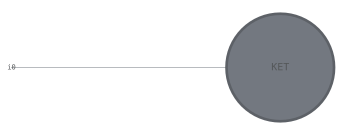

In [2]:
data = np.array([1., 2.])
ind = ("i0",)
tags = ("KET",)
ket = qtn.Tensor(data, inds=ind, tags=tags)
ket.draw()

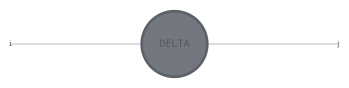

In [3]:
id2 = qtn.Tensor(np.array([[1., 0.], [0., 1.]]), inds=("i", "j"), tags=("DELTA",))
id2.draw()

The contraction of tensors are often denoted by Einstein's summation convention:
$$T_{ij}=A_{ik}B_{kj}\equiv \sum_{k=1}^{d_k}A_{ik}B_{kj},$$
where repeated indices suggest a summation. In the graphical notation, contraction is represented by simply connecting two edges (or, legs) of the the tensor. Multiple connected tensors are then called a tensor network.

TensorNetwork([
    Tensor(shape=(2, 2), inds=('i', 'k'), tags=oset(['A'])),
    Tensor(shape=(2, 2), inds=('k', 'j'), tags=oset(['B'])),
], tensors=2, indices=3)


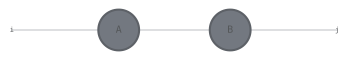

In [100]:
A_t = qtn.Tensor(np.array([[1., 2.], [2., 1.]]), inds=("i","k"), tags=("A",))
B = qtn.Tensor(np.array([[3., 4.], [1., 2.]]), inds=("k", "j"), tags=("B",))  # repeated name suggest connection automatically
AB_network = A_t & B
print(AB_network)
AB_network.draw(layout="sfdp")  # sfdp layout need pygraphviz installed

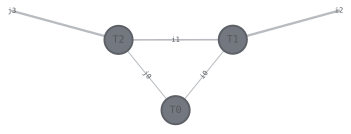

In [14]:
T0 = qtn.Tensor(np.random.random([2, 2]), inds=("i0", "j0",), tags=("T0",))
T1 = qtn.Tensor(np.random.random([2, 3, 5]), inds=("i0", "i1", "i2"), tags=("T1",))
T2 = qtn.Tensor(np.random.random([2, 3, 5]), inds=("j0", "i1", "j3"), tags=("T2",))
TN = qtn.TensorNetwork([T0, T1, T2])
TN.draw(show_inds="all")

The time to contract of tensors may vary greatly if the indices are contracted in different orders. Generally speaking, if two tensors are contracted: $T_{k,i_1,\dots,i_n}T_{k,j_1,\dots,j_m}$. The number of multiplications needed is $d_k \Pi_{l=p}^n d_{i_p} \Pi_{q=1}^md_{j_q}$. In the graphical notation, simply multiply the dimensions of the bond connecting two contracted nodes and legs of the resulting tensor.

Take matrix multiplication as an example. The multiplication of a $m\times n$ matrix A and a $n\times k$ matrix B takes $mnk$ multiplications. For the multiplication of three matrices A, B, C with respective shape $(m,n)$, $(n,k)$ and $(k,l)$, $(AB)C$ takes $(mnk)\cdot (mkl)=m^2nk^2l$ multiplications, but $A(BC)$ takes $(nkl)\cdot (mnl)=mn^2kl^2$ multiplications. It is possible to determinine the optimal multiplication order of matrices (rank 2 tensors) in polynomial time through, e.g., dynamic programming, but it is NP-hard for general high-rank tensors. There are some automatic contraction-path seeking algorithm implemented in most tensor network libraries.

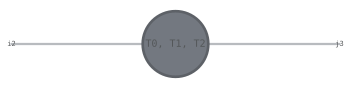

In [15]:
(TN ^ ...).draw()  # short hand to contract all tensors in a network

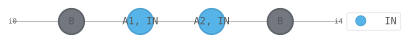

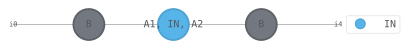

In [82]:
# contract a subgraph with a specific tag
TN_chain = qtn.TensorNetwork()
A0 = qtn.Tensor(np.random.random([2, 2]), inds=("i0", "i1"), tags=("B"))
A1 = qtn.Tensor(np.random.random([2, 2]), inds=("i1", "i2"), tags=("A1", "IN"))
A2 = qtn.Tensor(np.random.random([2, 2]), inds=("i2", "i3"), tags=("A2", "IN"))
A3 = qtn.Tensor(np.random.random([2, 2]), inds=("i3", "i4"), tags=("B"))
TN_chain.add_tensor(A0)
TN_chain &= [A1, A2, A3]
TN_chain.draw(color="IN", show_tags=True, layout="sfdp")
TNc = TN_chain ^ "IN"
TNc.draw(color="IN", layout="sfdp")  # for details of contraction path, see cotengra doc


## 1.2 SVD
The key to compressing tensors lies in SVD.
For an $m\times n$ matrix $A$, the singular value decomposition (SVD) splits it into three matrices $U\Sigma V^{\dagger}$, where $U$ and $V$ are $m\times m$ and $n\times n$ unitary matrices, and $\Sigma$ is a $m\times n$ "almost" diagonal matrix: only the "diagnoal" $\Sigma_{ii}$'s are non-zero, they are called the singular values.

In [15]:
A_t = np.random.random([5, 3])
U_t, S_t, Vd_t = np.linalg.svd(A_t, full_matrices=True)
print("U shape:", U_t.shape)
print("V dagger shape:", Vd_t.shape)
Sigma = np.zeros_like(A_t)  # sigma
Sigma[np.arange(3), np.arange(3)] = S_t  # S is a 1-dim list of singular values
print("A = U Sigma Vdagger:", np.allclose(A_t, U_t @ Sigma @ Vd_t))
print()
print("Sigma =")
print(Sigma)


U shape: (5, 5)
V dagger shape: (3, 3)
A = U Sigma Vdagger: True

Sigma =
[[2.22558859 0.         0.        ]
 [0.         0.63235403 0.        ]
 [0.         0.         0.23898828]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]


In the example above, it is evident that we only need to save the singular values in $\Sigma$, instead of the whole matrix. Furthermore, the whole matrix $\Sigma$ is of shape (5, 3) (same as $A$), but the last two rows are all 0's, so the last two columbs in $U$ can be safely discarded since they vanishes when doing multiplication $U\Sigma$. If the original matrix $A$ has more columns then rows, the last several rows of Vd can also be discarded similarly.

In [16]:
A_t = np.random.random([5, 3])
# SVD
U_t, S_t, Vd_t = np.linalg.svd(A_t, full_matrices=False)
print("U shape:", U_t.shape)
print("V dagger shape:", Vd_t.shape)
# reconstruction
print("A = U Sigma Vdagger:", np.allclose(A_t, U_t @ np.diag(S_t) @ Vd_t))

U shape: (5, 3)
V dagger shape: (3, 3)
A = U Sigma Vdagger: True


Now, in this more compact form, an $m\times n$ matrix $A$ (say, $m>n$), after SVD, results in an $m\times n$ $U$, an $n\times n$ $V^{\dagger}$ and $n$ singlular values, with $m\times n + n^2 + n$ elements in total. The singular value can be merged into $U$ or V^{\dagger}, leanding to $A=(U\Sigma)V^{\dagger}$, $U(\Sigma V^{\dagger})$ or $U(\sqrt{\Sigma})(\sqrt{\Sigma}V^{\dagger})$. In this cases, the matrix $A$ is split into a product of an $m\times n$ matrix and an $n \times n$ matrix, with $mn+n^2$ elements in total.

It seems less efficient to store the decomposed matrix. However, in some cases many singular values are small and negligible, keeping the greatest $D$ singular values suffice to recompose the onriginal data with good quality. Therefore, we only needs to pick the corresponding columns / rows in $U$ and $V^{\dagger}$. In the end, we only need to store $m\times D + D\times n + D$ elements to save the truncated $U$, $V^{\dagger}$ and $\Sigma$. If $\Sigma$ is merged into $U$ or/and $V^{\dagger}$, only $mD+Dn$ elements need to be stored.  If $D=O(1)$, then the space to store the whole matrix reduce from $O(mn)$ to $O(m+n)$, which is linear!
<!-- 
In the general case of a tensor $T_{a_1,a_2,\dots}$, we can reshape it into a matrix $T_{a_1,c}$ and split it into $A^{(1)}_{a_1,b_1}B_{b_1,c}$ throuth SVD, and then further decompose $B$, etc. This process will in the end decompose $T$ into a product of matrices, called a matrix product state (MPS): $$T=A^{(1)}A^{(2)}\dots$$. -->

In the graphical notation, SVD can be clearly denoted as the following.

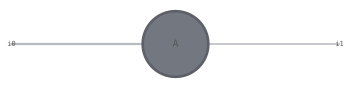

=


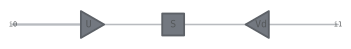

=


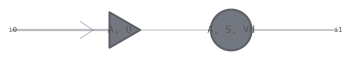

In [87]:
A = np.random.random([5, 3])
U, S, Vd = np.linalg.svd(A, full_matrices=False)
A_t = qtn.Tensor(A, inds=("i0", "i1"), tags="A")
A_t.draw()
print("=")
Vd_t = qtn.Tensor(Vd, inds=("k2", "i1"), tags="Vd")
U_t = qtn.Tensor(U, inds=("i0", "k1"), tags="U")
S_t = qtn.Tensor(np.diag(S), inds=("k2", "k1"), tags="S")
(U_t & S_t & Vd_t).draw(node_shape={"U": ">", "S": "s", "Vd": "<"}, layout="sfdp") 

print("=")
TN_split = A_t.split(left_inds="i0", method="svd", absorb="right", max_bond=2, ltags="U", rtags=("S", "Vd"))
TN_split.draw(layout="sfdp", node_shape={("A", "U"): ">"})

The U and Vd matrix are represented as a triangle to suggest there unitarity. The matrix $U$ is called left-normalized, and $V^{\dagger}$ is called right-normalized because $U^{\dagger}_{ik}U_{kj}= U^{*}_{ki} U_{kj}= \delta_{ij}$ and $V^{\dagger}_{ik}(V^{\dagger})^{\dagger}_{kj}=V^{\dagger}_{ik}(V^{\dagger})^*_{jk}=\delta_{ij}$, i.e.,
![fig](fig1left-norm.png) ![fig](fig2right-norm.png)

## 1.3 MPS & MPO
SVD is a good tool for compressing matrices, or rank-2 tensors. For high dimensional tensors, such as $T_{a_1,a_2,\dots}$, (eacy index has $d$ dimensions, with $d^n$ elements in total), one can do a "successive" SVD.
1. Reshape $T$ into $d\times d^{n-1}$ matrix $T_{a_1,c}$ and split it with SVD: $T_{a_1,c}=A^{(1)}_{a_1,b_1}B_{b_1,c}$. Suppose only $D$ dimensions are kept in the "bond" index $b_1$.
2. The remaining $D\times d^{n-1}$ matrix $B$ is then reshaped as a $(Dd)\times d^{n-2}$ matrix $B_{c_1,c_2}$, with $c_1=(b_1,a_2)$. $B$ is then further decomposed into $A^{(2)}_{c_1,b_2} C_{b_2,c_2}$, with $D$ diemsnions kept in $b_2$. The $A^{(2)}$ is then reshaped back to $A^{(2)}_{b_1,a_2,b_2}$.
3. Go on to decompose the remaining $C_{b_2,c_2}$...
4. In the end, we get
$$T_{a_1,a_2,\dots,a_n}=A^{(1)}_{a_1,b_1} A^{(2)}_{b_1,a_2,b_2}\dots A^{(n)}_{b_{n-1},a_n}.$$

The tensor is then represented as a matrix product. It is called a matrix product state (MPS). Each "local" tensor $A$ is rank 3 for the interior and rank 2 for the boundary. The $b$'s are called the bound indices (with dimension $D$), and the $a$'s are called the physical indices (with dimension $D$). If no truncation is introduced in the SVD's, the bond dimensions can go exponentially large, and MPS becomes useless. However, if all the bound indices $b_1,b_2,\dots$ are truncated so that they take no more than $D=O(1)$ dimension, the space needed to save the tensor is compressed to $O(N D^2 d)$, which is polynomial!

Since we will use MPS for wave functions, it is necessary to normalize them. The lcoal tensors $A$'s are left normlized if $A_{b_{i-1},a_i,b_{i}}A_{b_{i-1},a_i,b_{i}'}=\delta_{b_{i},b_{i}'}$ (the $U$ in SVD), and right normalized if $A_{b_{i-1},a_i,b_{i}}A_{b_{i-1}',a_i,b_{i}}=\delta_{b_{i-1},b_{i-1}'}$ (the $V^{\dagger}$ in SVD). The graphical notation is almost the same as the case mentioned above in 1.2, but the edge connecting two nodes should now be replaced by two edges representing a bound index and a physical index. The MPS are called in left-canonical form if all the local tensors are left-normalized, or in right-canonical form if all loal tensors are right-normalized. It is in canonical form if all local tensors left to a site is left-normalized, while all local tensors right to it is right-normalized. These canonical forms have nice properties: See 4.3.1 and 4.3.2 in [1] for details.
1. left and right canonical forms are really "normlized" (overlap is 1);
2. Site-canonical forms make computing expectation of a local operator easy (such as $S^{z}_i$ in the Heisenberg model.)

In [35]:
p = qtn.MPS_rand_state(L=6, bond_dim=5, phys_dim=2)  # an MPS with random indices
p.show()  # 1d TN can be "shown"

 5 5 5 5 5 
●─●─●─●─●─●
│ │ │ │ │ │


In [37]:
p.left_canonize()  # other functions: right_canonize, canonize
p.show()

 2 4 5 5 5 
>─>─>─>─>─●
│ │ │ │ │ │


In [56]:
# unitary check
first = p[0].data  # in general one should select a tensor through tags, but MPS supports int selection
print(np.allclose(first.T @ first, np.eye(2)))

second = p[1].data
print(np.allclose(np.einsum("ikj,ilj->kl", second, second), np.eye(4)))

last = p[-1].data
print(np.allclose(np.sum(last**2), 1))

True
True
True


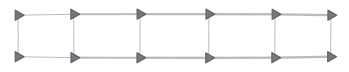

= 1.0000000000000002


In [62]:
# normalization check
(p.H & p).draw(show_tags=False, layout="sfdp", node_shape=">")
print("=", p.H @ p)

In [66]:
# addition
p2 = p + p
p2.show()
print(p[0].data)
print(p2[0].data)

 4 8 10 10 10 
●─●─●──●──●──●
│ │ │  │  │  │
[[-0.92919741  0.36958379]
 [-0.36958379 -0.92919741]]
[[-0.92919741  0.36958379]
 [-0.36958379 -0.92919741]
 [-0.92919741  0.36958379]
 [-0.36958379 -0.92919741]]


Now, the state (wave function) can be efficiently represented by an MPS, it is natrual to write the operators in a matrix product state, i.e., MPO's (matrix product operators). MPO's are similar to MPS's, but they have two rows of physical indicies (an "input" and an "output") to operate on the states.

In [76]:
O = qtn.MPO_rand_herm(L=6, bond_dim=3, phys_dim=2, tags="MPO")
O.show()

│3│3│3│3│3│
●─●─●─●─●─●
│ │ │ │ │ │


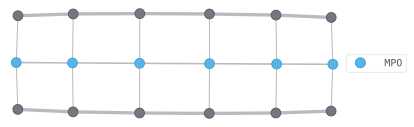

= 0.015523576106219412


In [9]:
# A contraction
O = qtn.MPO_rand_herm(L=6, bond_dim=3, phys_dim=2, tags="MPO")
p = qtn.MPS_rand_state(L=6, bond_dim=10, phys_dim=2)
pH = p.H
p.align_(O, pH)  # using align_ is correct (inplace), not align here
contract = pH & O & p
contract.draw(show_tags=False, color="MPO", initial_layout="kamada_kawai")
print("=", contract ^...)

Now, constructing an MPO hamiltonian is not an easy job. For local models such as the Heisenberg model, there is an analytic form (introduced in [1]). For more complicated Hamiltonians such as the quantum chemistry ab initio Hamiltonian, the construction is not straightforward (see for example [3]). In this notebook, we won't into the details and will just fully use the already-implemented functionality in quimb. For example, the code below use `SpinHam1D` to construct the MPO of a Heisenberg spin-1 model (with externel field) $$H=J\sum_{i=1}^{N-1}\left(S_i^z S_{i+1}^z+\frac{S_i^{+}S_i^{-}+S_i^{-}S_{i+1}^+}{2}\right)-h\sum_{i=1}^NS_i^z.$$

In [2]:
J = 1.
h = 1.
builder = qtn.SpinHam1D(S=1, cyclic=False)
builder += 1.0 * J, "Z", "Z"  # two-site terms: Sz Sz
builder += 0.5 * J, "+", "-"
builder += 0.5 * J, "-", "+"  # two-site terms: S+ S-, S- S+
builder -= h, "Z"  # on-site terms
H_hs = builder.build_mpo(L=10)
H_hs.show()


│5│5│5│5│5│5│5│5│5│
●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │


In [4]:
H_hs = qtn.MPO_ham_heis(L=10, j=1., bz=1., S=1, cyclic=False)  # the Heisenberg model has already been built in quimb
H_hs.show()

│5│5│5│5│5│5│5│5│5│
●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │


# 2 DMRG

## 2.1 DMRG algorithm
DMRG algorithm, in short, is actually minimizing the energy integral with the MPS wave function ansatz. The MPS is composed of several local tensors $A^{(i)}_{b_{i-1}a_i b_{i}}$. In principle, one should set the derivative of energy with respect to all local tensors (all elements) and set it to zero. However, this is usually impractical because the complete MPS is too larte. Instead, in DMRG, we optimize only one local tensor at each step, and treat other local tensors as some kind of "environment".

More specifically, let the MPS be $|\psi\rangle$ and the Hamiltonian be $H$. We minimize $\langle \psi | H | \psi\rangle - \lambda \langle \psi | \psi \rangle$ (the $\lambda$ part is a Lagrange multiplier for the constraint $\langle \psi | \psi \rangle = 1$). In each step, we solve $$\frac{\partial }{\partial A^{(i)}} (\langle \psi | H | \psi\rangle - \lambda \langle \psi | \psi \rangle) = 0.$$ The algorithm starts from a random MPS, and replace $A^{(1)}$ with the optimized one solved from the equation, then do the same thing to $A^{(2)}$, $A^{(3)}$, ... until we get to the end of the chain $A^{(n)}$. After that, we optimize these local tensor in a reverse order: first $A^{(n-1)}$, then $A^{(n-2)}$,... and stops at $A^{(1)}$. This procedure ($A^{(1)}$ to $A^{(n)}$ and back to $A^{(1)}$) is called a sweep. The energy will greadully converges after several sweeps.

As for how to solve a local optimization, note that $\frac{\partial }{\partial A^{(i)}} (\langle \psi | H | \psi\rangle - \lambda \langle \psi | \psi \rangle) = 0$ can be transformed to a local eigen value problem (by casting $|\psi\rangle$ in a $i$-site canonical form), just like the HF methods: (Note that the derivative w.r.t. to $A$ is different from the derivative w.r.t. $A^{*}$.) $$M_i A^{(i)} = \lambda A^{(i)}.$$ The local operator is: (retrieved from [1]) ![fig](fig3local-M.png)
We just pick the eigen vector of the lowest eigen state as $A^{(i)}$. However, the MPS must kept in the correct site-canonical form for the optimization of next tensor, so the solved $A^{(i)}$ is decomposed into $U\lambda V^{\dagger}$ through SVD, and truncated with bond dimensions no more than $D$. The unitary matrix $U$ is treated as chosen as $A^{(i)}$ while $\lambda V^{\dagger}$ is merged into $A^{(i+1)}$ before optimizing $A^{(i+1)}$.

Furthermore, we can also take the derivative with two sites at one time, leading to the 2-site DMRG with a higher accuracy.

DMRG has already been implemented in the various libraries, and I will not implement it again here.


In [27]:
H_hs = qtn.MPO_ham_heis(L=15, j=1., bz=1., S=1, cyclic=False)  # the Heisenberg model has already been built in quimb
H_hs.show()

│5│5│5│5│5│5│5│5│5│5│5│5│5│5│
●─●─●─●─●─●─●─●─●─●─●─●─●─●─●
│ │ │ │ │ │ │ │ │ │ │ │ │ │ │


In [28]:
dmrg = qtn.DMRG1(H_hs, bond_dims=[10, 20, 100, 100, 200], cutoffs=1e-10)  # one-site DMRG
dmrg.solve(tol=1e-4, verbosity=1)

1, R, max_bond=(10/10), cutoff:1e-10


100%|##########################################| 15/15 [00:00<00:00, 466.24it/s]

Energy: -21.121292551985846 ... not converged.
2, R, max_bond=(10/20), cutoff:1e-10



100%|##########################################| 15/15 [00:00<00:00, 113.44it/s]

Energy: -21.22515774141518 ... not converged.
3, R, max_bond=(20/100), cutoff:1e-10



100%|###########################################| 15/15 [00:02<00:00,  5.59it/s]

Energy: -21.229124810531356 ... not converged.
4, R, max_bond=(100/100), cutoff:1e-10



100%|###########################################| 15/15 [00:03<00:00,  4.87it/s]

Energy: -21.229398847806312 ... not converged.
5, R, max_bond=(100/200), cutoff:1e-10



100%|###########################################| 15/15 [00:16<00:00,  1.07s/it]

Energy: -21.22943388710824 ... converged!


True

In [30]:
sol = dmrg.state
sol.show()

 3 9 27 81 200 200 200 200 200 200 81 27 9 3 
>─>─>──>──>━━━>━━━>━━━>━━━>━━━>━━━>──>──>─>─●
│ │ │  │  │   │   │   │   │   │   │  │  │ │ │


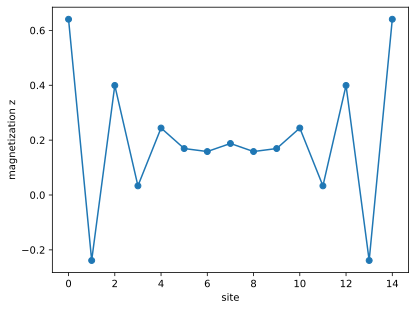

In [32]:
mag = [sol.magnetization(i, direction="Z") for i in range(15)]
plt.plot(mag, marker="o")
plt.xlabel("site")
plt.ylabel("magnetization z")
plt.show()

## 2.2 Discussion
DMRG is very successful in (quasi-) 1d systems, as is clearly explained in [1] and [4]. In the original formulation, DMRG is actually "truncating" the overall density matrix, i.e., projecting the hamiltonian into subspace spanned by the $D$ eigen vectors of the density matrix with the highest eigen values. This equivelant to the truncation in SVD of the MPS formalism. Now, there is a connection between the density matrix and the entanglement entropy $S$ (between a "left block" and a "right block"), and it can be shown that the truncation dimension $D$ should be of the order $2^S$ for DMRG to be accurate. If $D$ must be exponentially large, DMRG won't be far better than brute-forth diagnolization.

Now, for some peculiar systems, $S$ is proportional to the surface area (instead of volumn) of the system, i.e., $S\propto L^{d-1}$, this is called the area law. In many systems in 1d, the area law holds, so that $S\propto L^0$ and $D=O(1)$ (or in some cases $S\propto \log L$ and $D=O(L)$), making DMRG significanly more efficient than brute-forth diagonlization. However, DMRG is still useful in more complicated systems (such as the ab inito hamiltonian in quantum chemistry) [4].

# Reference
[1] G. Catarina and B. Murta, Density-Matrix Renormalization Group: A Pedagogical Introduction, Eur. Phys. J. B 96, 111 (2023).

[3] S. Keller, M. Dolfi, M. Troyer, and M. Reiher, An Efficient Matrix Product Operator Representation of the Quantum Chemical Hamiltonian, The Journal of Chemical Physics 143, 244118 (2015).

[4] G. K.-L. Chan and S. Sharma, The Density Matrix Renormalization Group in Quantum Chemistry, Annu. Rev. Phys. Chem. 62, 465 (2011).

